# **Model Training for the Forest Covertypes Data**

![Image](https://cdn.shopify.com/s/files/1/0326/7189/t/65/assets/pf-85b5b49e--Website-Header-2000px-x-600px.jpg?v=1625226604)

[Image Credit](https://onetreeplanted.org/pages/million-tree-challenge) <br>

In this notebook, the data of **Forest Cover Type Prediction** is used to develop prediction models. <br>
The data can be downloaded from: <br>
https://www.kaggle.com/competitions/forest-cover-type-prediction/data 

In [156]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import os

# to bypass warnings in various dataframe assignments
pd.options.mode.chained_assignment = None

pd.set_option('display.max_columns', 60)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RepeatedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [94]:
# Loading data
train = pd.read_csv("data/processed/train.csv")
test = pd.read_csv("data/processed/test.csv")

sample_submission = pd.read_csv("data/raw/sampleSubmission.csv")

## **1. Feature-Label:**
The first thing we need to do is separating the label from the features.

In [86]:
# Splitting data into features and labels
x_train = train.drop(['Cover_Type','Id'], axis=1)
y_train = train['Cover_Type']

x_test = test.drop(['Id'], axis=1)

Since we are going to implement cross-validation and considering that we already have a blind test set, we do not split the training set to train-validation. 

In [88]:
# checking the shape of the data
print("Shape of training input: ", x_train.shape)
print("Shape of training labels: ", y_train.shape)
print("Shape of test input: ", x_test.shape)

Shape of training input:  (14988, 54)
Shape of training labels:  (14988,)
Shape of test input:  (565892, 54)


## **2. Creating Baseline Model:**
In this section, we create a baseline model which is used as a benchmark to compare the performance of the other models. <br>
This model is usually a simple method of predicting labels based on the relationships between the features and the target. If there are obvious relationships, we can make predictions based on that. If we have access to an expert who is aware of such relationships based on the underlying technical principles, we can code it to arrive at some predictions. <br>
Considering the lack of the above knwoledge, we make the baseline predictions based on a stratified selection from the target classes using `DummyClassifier` as follows.

In [89]:
# Create dummy classifer
dummy = DummyClassifier(strategy='stratified', random_state=1)

# train the model
dummy.fit(x_train, y_train)

# accuracy score of the model on the training set
accuracy_dm = dummy.score(x_train, y_train)
print(f'The accuracy of the dummy algorithm is {accuracy_dm.round(3)} over the training set.')

The accuracy of the dummy algorithm is 0.141 over the training set.


As can be seen, the dummy classifier could predict only 13.5 % of the labels correctly in the validation set. <br>
It's time to try other classifiers.

## **3. Developing Prediction Models Using All Features:**
In this section, we develop several machine learning models to predict the cover types in the validation set. <br>
These models are:
* Logistic Regression
* K-Nearest Neighbors
* Decision Tree
* Gradient Boosting Tree
* Random Forest
* Extra Trees (Extreme Random Forest)

In order to make sure the best models will be fitted on the data, 5-fold cross validation together with hyperparameters tuning based on Bayesian optimization is applied to all the models. <br>

**Standardizing data before training?** <br>

For some algorithms, it is very important to scale data before training the models. This can significantly affect the performance of the models. Some comparisons between the performance of models developed using scaled data and unscaled data can be found [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html). It states that:

> Even if tree based models are (almost) not affected by scaling, many other algorithms require features to be normalized, often for different reasons: to ease the convergence (such as a non-penalized logistic regression), to create a completely different model fit compared to the fit with unscaled data (such as KNeighbors models). The latter is demoed on the first part of the present example.

So, we first standardize the data based on Z-score normalization as follows:

In [90]:
# standardize the train, validation, and test data all based on the training data excluding binary features
binary_features = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 
'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13',
 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 
 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 
 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']

# standardize the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.drop(binary_features, axis=1))
x_test_scaled = scaler.transform(x_test.drop(binary_features, axis=1))

# convert the numpy arrays to dataframes
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.drop(binary_features, axis=1).columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.drop(binary_features, axis=1).columns)

# add the binary features back to the dataframes
x_train_scaled = pd.concat((x_train_scaled, x_train[binary_features].reset_index(drop=True)), axis=1)
x_test_scaled = pd.concat((x_test_scaled, x_test[binary_features].reset_index(drop=True)), axis=1)

# check the shape of the data
print("Shape of training input: ", x_train_scaled.shape)
print("Shape of test input: ", x_test_scaled.shape)

Shape of training input:  (14988, 54)
Shape of test input:  (565892, 54)


### **3.1 Model 1: Logistic Regression**
The first model we are going to develop is logistic regression using `LogisticRegression` from scikit-learn.

In [112]:
model = LogisticRegression(solver='newton-cg', multi_class='multinomial')
param_grid = {'fit_intercept' : [False, True],
              'C'             : Real(1e-3, 100, prior='log-uniform')}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search1 = BayesSearchCV(estimator=model, search_spaces=param_grid, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search1.fit(x_train_scaled, y_train)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=LogisticRegression(multi_class='multinomial',
                                           solver='newton-cg'),
              n_jobs=-1, random_state=1, return_train_score=True,
              search_spaces={'C': Real(low=0.001, high=100, prior='log-uniform', transform='normalize'),
                             'fit_intercept': [False, True]})

Lets check the average CV scores and the best hyperparameters:

In [119]:
accuracy_lr_cv_train = search1.cv_results_['mean_train_score'][search1.best_index_].round(4)
accuracy_lr_cv_val = search1.cv_results_['mean_test_score'][search1.best_index_].round(4)

print(f"Optimal hyperparameters of the model = {search1.best_params_}")
print(f"CV AVG train score of the model = {accuracy_lr_cv_train}")
print(f"CV AVG validation score of the model = {accuracy_lr_cv_val}")

Optimal hyperparameters of the model = OrderedDict([('C', 2.7502092219694063), ('fit_intercept', True)])
CV AVG train score of the model = 0.7137
CV AVG validation score of the model = 0.7081


Now, it is time to build model with the optimal hyperparameters using the whole training data (without cross-validation). Then, make final predictions on the blind test data.

In [114]:
# train model with optimal hyperparameters on the entire training data
model1 = LogisticRegression(solver='newton-cg', multi_class='multinomial', **search1.best_params_)
model1.fit(x_train_scaled, y_train)

# check the accuracy of the model on the training data itself
y_pred = model1.predict(x_train_scaled)
accuracy_lr_train = accuracy_score(y_train, y_pred)
print(f'The accuracy of the model over the training data is {accuracy_lr_train.round(3)}.')

# make predictions on the test data
y_pred = model1.predict(x_test_scaled)
y_pred.shape

The accuracy of the model over the training data is 0.713.


(565892,)

We make a csv file of the predictions to submit it.

In [117]:
submission1 = sample_submission.copy()
submission1['Cover_Type'] = y_pred

# Save the submission file
submission1.to_csv('data/prediction/submission1.csv', index=False)

# Check the submission file
submission1['Cover_Type'].value_counts()

1    201932
2    187825
5     67134
7     43203
6     32439
3     27185
4      6174
Name: Cover_Type, dtype: int64

In [144]:
# based on Kaggle 
accuracy_lr_test = 0.597

##### **Final Scores: CV train = 0.7137 | CV validation = 0.7081 | test (blind): 0.597** <br>
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________

### **3.2 Model 2: K-Nearest Neighbors**
The second model we are going to develop is k-nearest neighbors using `KNeighborsClassifier` from scikit-learn.

In [121]:
model = KNeighborsClassifier()
param_grid = {'n_neighbors' : Integer(1,40), 
              'weights'     : Categorical(['uniform', 'distance'])}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search2 = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search2.fit(x_train_scaled, y_train)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=KNeighborsClassifier(), n_iter=10, n_jobs=-1,
              random_state=1, return_train_score=True,
              search_spaces={'n_neighbors': Integer(low=1, high=40, prior='uniform', transform='normalize'),
                             'weights': Categorical(categories=('uniform', 'distance'), prior=None)})

Lets check the average CV scores and the best hyperparameters:

In [122]:
accuracy_knn_cv_train = search2.cv_results_['mean_train_score'][search2.best_index_].round(4)
accuracy_knn_cv_val = search2.cv_results_['mean_test_score'][search2.best_index_].round(4)

print(f"Optimal hyperparameters of the model = {search2.best_params_}")
print(f"CV AVG train score of the model = {accuracy_knn_cv_train}")
print(f"CV AVG validation score of the model = {accuracy_knn_cv_val}")

Optimal hyperparameters of the model = OrderedDict([('n_neighbors', 6), ('weights', 'uniform')])
CV AVG train score of the model = 0.8493
CV AVG validation score of the model = 0.7846


Now, it is time to build model with the optimal hyperparameters using the whole training data (without cross-validation). Then, make final predictions on the blind test data.

In [123]:
# train model with optimal hyperparameters on the entire training data
model2 = KNeighborsClassifier(**search2.best_params_)
model2.fit(x_train_scaled, y_train)

# check the accuracy of the model on the training data itself
y_pred = model2.predict(x_train_scaled)
accuracy_knn_train = accuracy_score(y_train, y_pred)
print(f'The accuracy of the model over the training data is {accuracy_knn_train.round(3)}.')

# make predictions on the test data
y_pred = model2.predict(x_test_scaled)
y_pred.shape

c:\Users\MIO\.conda\envs\envtf\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


The accuracy of the model over the training data is 0.858.


c:\Users\MIO\.conda\envs\envtf\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


(565892,)

We make a csv file of the predictions to submit it.

In [124]:
submission2 = sample_submission.copy()
submission2['Cover_Type'] = y_pred

# Save the submission file
submission2.to_csv('data/prediction/submission2.csv', index=False)

# Check the submission file
submission2['Cover_Type'].value_counts()

1    217106
2    187152
5     55709
7     37077
3     35520
6     28654
4      4674
Name: Cover_Type, dtype: int64

In [145]:
# based on Kaggle 
accuracy_knn_test = 0.643

##### **Final Scores: CV train = 0.8493 | CV validation = 0.7846 | test (blind): 0.643** <br>
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________

### **3.3 Model 3: Decision Tree**
The third model we are going to develop is decision tree using `DecisionTreeClassifier` from scikit-learn.

In [125]:
model = DecisionTreeClassifier()
param_grid = {'max_depth':Integer(1,30)}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search3 = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search3.fit(x_train_scaled, y_train)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=DecisionTreeClassifier(), n_iter=10, n_jobs=-1,
              random_state=1, return_train_score=True,
              search_spaces={'max_depth': Integer(low=1, high=30, prior='uniform', transform='normalize')})

Lets check the average CV scores and the best hyperparameters:

In [126]:
accuracy_dt_cv_train = search3.cv_results_['mean_train_score'][search3.best_index_].round(4)
accuracy_dt_cv_val = search3.cv_results_['mean_test_score'][search3.best_index_].round(4)

print(f"Optimal hyperparameters of the model = {search3.best_params_}")
print(f"CV AVG train score of the model = {accuracy_dt_cv_train}")
print(f"CV AVG validation score of the model = {accuracy_dt_cv_val}")

Optimal hyperparameters of the model = OrderedDict([('max_depth', 21)])
CV AVG train score of the model = 0.9935
CV AVG validation score of the model = 0.7971


Now, it is time to build model with the optimal hyperparameters using the whole training data (without cross-validation). Then, make final predictions on the blind test data.

In [127]:
# train model with optimal hyperparameters on the entire training data
model3 = DecisionTreeClassifier(**search3.best_params_)
model3.fit(x_train_scaled, y_train)

# check the accuracy of the model on the training data itself
y_pred = model3.predict(x_train_scaled)
accuracy_dt_train = accuracy_score(y_train, y_pred)
print(f'The accuracy of the model over the training data is {accuracy_dt_train.round(3)}.')

# make predictions on the test data
y_pred = model3.predict(x_test_scaled)
y_pred.shape

The accuracy of the model over the training data is 0.994.


(565892,)

We make a csv file of the predictions to submit it.

In [128]:
submission3 = sample_submission.copy()
submission3['Cover_Type'] = y_pred

# Save the submission file
submission3.to_csv('data/prediction/submission3.csv', index=False)

# Check the submission file
submission3['Cover_Type'].value_counts()

2    223022
1    206127
5     38723
3     35546
7     34382
6     25428
4      2664
Name: Cover_Type, dtype: int64

In [146]:
# based on Kaggle 
accuracy_dt_test = 0.672

##### **Final Scores: CV train = 0.9935 | CV validation = 0.7971 | test (blind): 0.672** <br>
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________

### **3.4 Model 4: Gradient Boosting Tree**
The fourth model we are going to develop is gradient boosting tree using `GradientBoostingClassifier` from scikit-learn.

In [129]:
model = GradientBoostingClassifier()
param_grid = {'max_depth'     : Integer(1,20), 
              'learning_rate' : Real(1e-3, 1, prior='log-uniform'),
              'n_estimators'  : Integer(1,300)}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search4 = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search4.fit(x_train_scaled, y_train)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=GradientBoostingClassifier(), n_iter=10, n_jobs=-1,
              random_state=1, return_train_score=True,
              search_spaces={'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=1, high=300, prior='uniform', transform='normalize')})

Lets check the average CV scores and the best hyperparameters:

In [130]:
accuracy_gbt_cv_train = search4.cv_results_['mean_train_score'][search4.best_index_].round(4)
accuracy_gbt_cv_val = search4.cv_results_['mean_test_score'][search4.best_index_].round(4)

print(f"Optimal hyperparameters of the model = {search4.best_params_}")
print(f"CV AVG train score of the model = {accuracy_gbt_cv_train}")
print(f"CV AVG validation score of the model = {accuracy_gbt_cv_val}")

Optimal hyperparameters of the model = OrderedDict([('learning_rate', 0.021992361138544005), ('max_depth', 11), ('n_estimators', 260)])
CV AVG train score of the model = 1.0
CV AVG validation score of the model = 0.8634


Now, it is time to build model with the optimal hyperparameters using the whole training data (without cross-validation). Then, make final predictions on the blind test data.

In [131]:
# train model with optimal hyperparameters on the entire training data
model4 = GradientBoostingClassifier(**search4.best_params_)
model4.fit(x_train_scaled, y_train)

# check the accuracy of the model on the training data itself
y_pred = model4.predict(x_train_scaled)
accuracy_gbt_train = accuracy_score(y_train, y_pred)
print(f'The accuracy of the model over the training data is {accuracy_gbt_train.round(3)}.')

# make predictions on the test data
y_pred = model4.predict(x_test_scaled)
y_pred.shape

The accuracy of the model over the training data is 1.0.


(565892,)

We make a csv file of the predictions to submit it.

In [132]:
submission4 = sample_submission.copy()
submission4['Cover_Type'] = y_pred

# Save the submission file
submission4.to_csv('data/prediction/submission4.csv', index=False)

# Check the submission file
submission4['Cover_Type'].value_counts()

2    235714
1    209589
3     35927
7     29720
5     28529
6     24237
4      2176
Name: Cover_Type, dtype: int64

In [147]:
# based on Kaggle 
accuracy_gbt_test = 0.761

##### **Final Scores: CV train = 1.0 | CV validation = 0.8634 | test (blind): 0.761** <br>
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________

### **3.5 Model 5: Random Forest**
The fifth model we are going to develop is random forest using `RandomForestClassifier` from scikit-learn.

In [134]:
model = RandomForestClassifier()
param_grid = {'n_estimators': [100,200,300,400],
              'bootstrap':    [True], 
              'max_depth':    Integer(1,20), 
              'max_features': Integer(1,16),
              'max_samples':  [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.999999]}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search5 = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search5.fit(x_train_scaled, y_train)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=RandomForestClassifier(), n_iter=10, n_jobs=-1,
              random_state=1, return_train_score=True,
              search_spaces={'bootstrap': [True],
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'max_features': Integer(low=1, high=16, prior='uniform', transform='normalize'),
                             'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                             0.8, 0.9, 0.999999],
                             'n_estimators': [100, 200, 300, 400]})

Lets check the average CV scores and the best hyperparameters:

In [135]:
accuracy_rf_cv_train = search5.cv_results_['mean_train_score'][search5.best_index_].round(4)
accuracy_rf_cv_val = search5.cv_results_['mean_test_score'][search5.best_index_].round(4)

print(f"Optimal hyperparameters of the model = {search5.best_params_}")
print(f"CV AVG train score of the model = {accuracy_rf_cv_train}")
print(f"CV AVG validation score of the model = {accuracy_rf_cv_val}")

Optimal hyperparameters of the model = OrderedDict([('bootstrap', True), ('max_depth', 15), ('max_features', 13), ('max_samples', 0.6), ('n_estimators', 300)])
CV AVG train score of the model = 0.9632
CV AVG validation score of the model = 0.8471


Now, it is time to build model with the optimal hyperparameters using the whole training data (without cross-validation). Then, make final predictions on the blind test data.

In [136]:
# train model with optimal hyperparameters on the entire training data
model5 = RandomForestClassifier(**search5.best_params_)
model5.fit(x_train_scaled, y_train)

# check the accuracy of the model on the training data itself
y_pred = model5.predict(x_train_scaled)
accuracy_rf_train = accuracy_score(y_train, y_pred)
print(f'The accuracy of the model over the training data is {accuracy_rf_train.round(3)}.')

# make predictions on the test data
y_pred = model5.predict(x_test_scaled)
y_pred.shape

The accuracy of the model over the training data is 0.96.


(565892,)

We make a csv file of the predictions to submit it.

In [137]:
submission5 = sample_submission.copy()
submission5['Cover_Type'] = y_pred

# Save the submission file
submission5.to_csv('data/prediction/submission5.csv', index=False)

# Check the submission file
submission5['Cover_Type'].value_counts()

2    215549
1    210891
5     40824
3     36243
7     32981
6     26620
4      2784
Name: Cover_Type, dtype: int64

In [148]:
# based on Kaggle 
accuracy_rf_test = 0.719

##### **Final Scores: CV train = 0.9632 | CV validation = 0.8471 | test (blind): 0.719** <br>
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________

### **3.6 Model 6: Extra Trees**
The sixth model we are going to develop is extra trees using `ExtraTreesClassifier` from scikit-learn.

In [140]:
model = ExtraTreesClassifier()
param_grid = {'n_estimators': [100,200,300,400],
              'bootstrap':    [True], 
              'max_depth':    Integer(1,20), 
              'max_features': Integer(1,16),
              'max_samples':  [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.999999]}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search6 = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search6.fit(x_train_scaled, y_train)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=ExtraTreesClassifier(), n_iter=10, n_jobs=-1,
              random_state=1, return_train_score=True,
              search_spaces={'bootstrap': [True],
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'max_features': Integer(low=1, high=16, prior='uniform', transform='normalize'),
                             'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                             0.8, 0.9, 0.999999],
                             'n_estimators': [100, 200, 300, 400]})

Lets check the average CV scores and the best hyperparameters:

In [141]:
accuracy_et_cv_train = search6.cv_results_['mean_train_score'][search6.best_index_].round(4)
accuracy_et_cv_val = search6.cv_results_['mean_test_score'][search6.best_index_].round(4)

print(f"Optimal hyperparameters of the model = {search6.best_params_}")
print(f"CV AVG train score of the model = {accuracy_et_cv_train}")
print(f"CV AVG validation score of the model = {accuracy_et_cv_val}")

Optimal hyperparameters of the model = OrderedDict([('bootstrap', True), ('max_depth', 15), ('max_features', 13), ('max_samples', 0.6), ('n_estimators', 300)])
CV AVG train score of the model = 0.9264
CV AVG validation score of the model = 0.8302


Now, it is time to build model with the optimal hyperparameters using the whole training data (without cross-validation). Then, make final predictions on the blind test data.

In [142]:
# train model with optimal hyperparameters on the entire training data
model6 = ExtraTreesClassifier(**search6.best_params_)
model6.fit(x_train_scaled, y_train)

# check the accuracy of the model on the training data itself
y_pred = model6.predict(x_train_scaled)
accuracy_et_train = accuracy_score(y_train, y_pred)
print(f'The accuracy of the model over the training data is {accuracy_et_train.round(3)}.')

# make predictions on the test data
y_pred = model6.predict(x_test_scaled)
y_pred.shape

The accuracy of the model over the training data is 0.92.


(565892,)

We make a csv file of the predictions to submit it.

In [143]:
submission6 = sample_submission.copy()
submission6['Cover_Type'] = y_pred

# Save the submission file
submission6.to_csv('data/prediction/submission6.csv', index=False)

# Check the submission file
submission6['Cover_Type'].value_counts()

2    213497
1    207770
5     45101
3     35289
7     33096
6     27503
4      3636
Name: Cover_Type, dtype: int64

In [149]:
# based on Kaggle 
accuracy_et_test = 0.698

##### **Final Scores: CV train = 0.9264 | CV validation = 0.8302 | test (blind): 0.698** <br>
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________

### **3.7 Comparing Models**
Here, we compare all the accuracy scores of the models developed so far. <br>

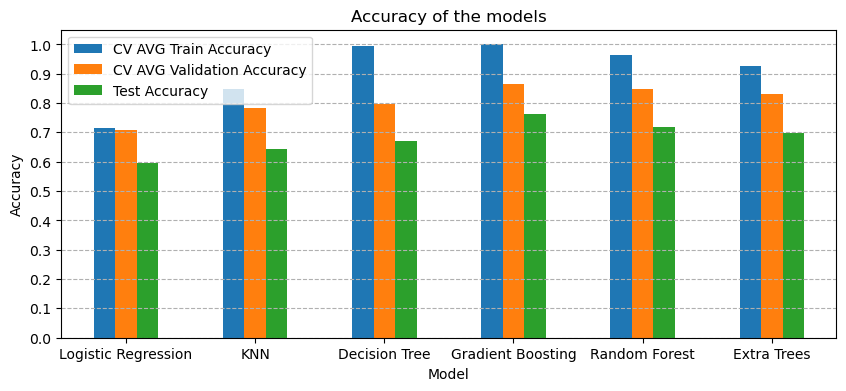

In [154]:
# compare accuracy of the models (CV train, CV validation, test)
accuracy = pd.DataFrame({'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Gradient Boosting', 'Random Forest', 'Extra Trees'],
                            'CV AVG Train Accuracy': [accuracy_lr_cv_train, accuracy_knn_cv_train, accuracy_dt_cv_train, accuracy_gbt_cv_train, accuracy_rf_cv_train, accuracy_et_cv_train],
                            'CV AVG Validation Accuracy': [accuracy_lr_cv_val, accuracy_knn_cv_val, accuracy_dt_cv_val, accuracy_gbt_cv_val, accuracy_rf_cv_val, accuracy_et_cv_val],
                            'Test Accuracy': [accuracy_lr_test, accuracy_knn_test, accuracy_dt_test, accuracy_gbt_test, accuracy_rf_test, accuracy_et_test]})
accuracy.sort_values(by='Test Accuracy', ascending=True)

# plot the accuracy of the models (CV train, CV validation, test)
accuracy.plot(x='Model', y=['CV AVG Train Accuracy', 'CV AVG Validation Accuracy', 'Test Accuracy'], kind='bar', figsize=(10,4), title='Accuracy of the models', rot=0)
plt.ylabel('Accuracy')
# set y axis values by 0.1 interval
plt.yticks(np.arange(0, 1.1, 0.1))
# Add horizontal grid lines for y axis
plt.grid(axis='y', linestyle='--')
plt.show()


As can be seen, the **gradient boosting tree model** outperforms other models considering cross-validation scores and blind test scores.

### **3.8 More About Best Model**
Here, we take a look at the confusion matrix for the predictions of the best model and the feature importances. Considering the fact that the true labels of the test set are not available and we used the full train set to develop the models with cross-validation, we split the train set into train-validation (80%-20%), develop the best model on the train set, and make predictions on the validation set. Then, we take a look at the confusion matrix for the predictions of the validation set.

In [158]:
# split the training data into train and validation data (80:20) as a holdout case
x_train_ho, x_val_ho, y_train_ho, y_val_ho = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=1)

# train the best model on the (x_train_ho, y_train_ho) data
model = GradientBoostingClassifier(**search4.best_params_)
model.fit(x_train_ho, y_train_ho)

# check the accuracy of the model on the validation data
y_pred = model.predict(x_val_ho)
accuracy_gbt_ho = accuracy_score(y_val_ho, y_pred)
print(f'The accuracy of the model over the validation data is {accuracy_gbt_ho.round(3)}.')

The accuracy of the model over the validation data is 0.856.


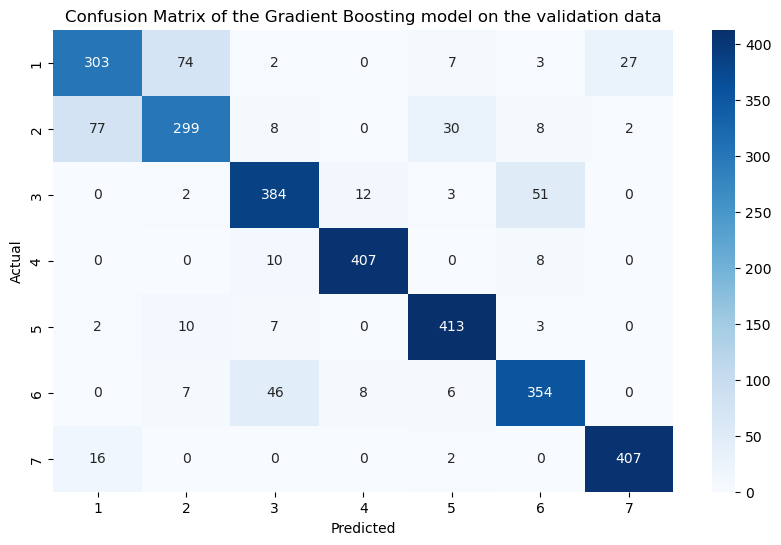

In [159]:
# visualize confusion matrix of the best model (Gradient Boosting) on the validation data
cm = confusion_matrix(y_val_ho, y_pred)
cm = pd.DataFrame(cm, index=range(1,8), columns=range(1,8))
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of the Gradient Boosting model on the validation data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

As can be seen, the major part of the misclassification has happened for cover types 1 and 2. The model has the best performance on cover types 4, 5, and 7 with the largest truely classified labels. <br>
Lets take a look at the feature importance values.

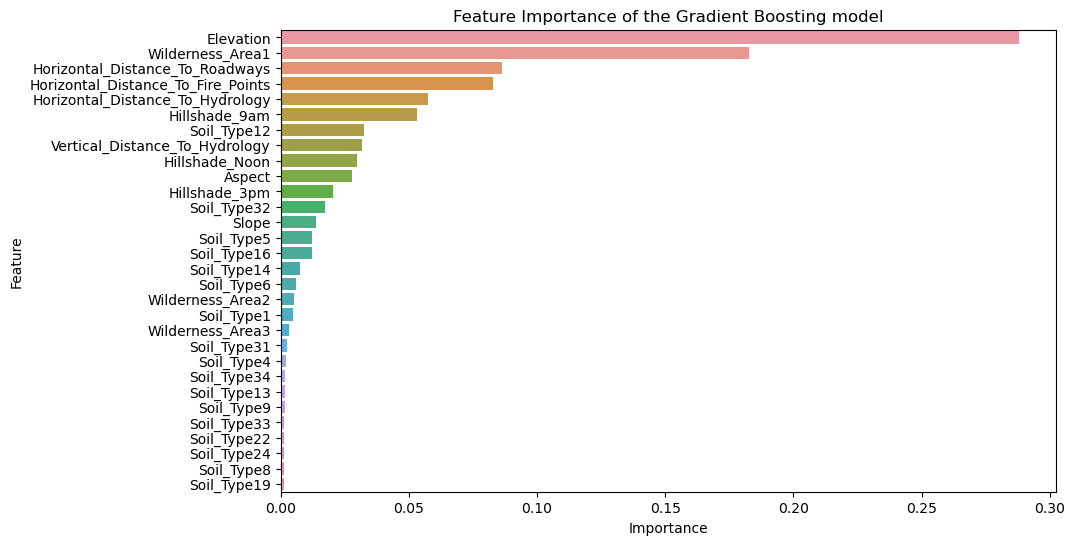

In [167]:
# visualize the feature importance of the best model (Gradient Boosting) for the first 30 most important features
feature_importance = pd.DataFrame({'Feature': x_train.columns, 'Importance': model4.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance[:30])
plt.title('Feature Importance of the Gradient Boosting model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

As can be seen, the most important features are : <br>
    1. `Elevation` <br>
    2. `Wilderness_Area1` <br>
    3. `Horizontal_Distance_To_Roadways` <br>
    4. `Horizontal_Distance_To_Fire_Points` <br>
    5. `Horizontal_Distance_To_Hydrology` <br>
    6. `Hillshade_9am` <br>

That is while based on the previous data analysis, the six features with the largest correlation with the target are: <br>
    1. `Soil_Type38` <br>
    2. `Soil_Type39` <br>
    3. `Wilderness_Area1` <br>
    4. `Soil_Type40` <br>
    5. `Soil_Type29` <br>
    6. `Soil_Type22` <br>

Moreover, the six features with the largest PP score are: <br>
    1. `Soil_Type_code` <br>
    2. `Elevation` <br>
    3. `Horizontal_Distance_To_Roadways` <br>
    4. `Horizontal_Distance_To_Hydrology` <br>
    5. `Hillshade_9am` <br>
    6. `Vertical_Distance_To_Hydrology` <br>

## **4. Developing Separate Models for Each Wilderness Area:**
As shown in the data analysis stage, the frequency of the target labels in each wilderness area is different from the other. Moreover, the PP score of the features are different for wilderness areas. Hence, we try developing separate models for each wilderness area and compare the performance of the models with the previous ones. We use gradient boosting trees for this purpose.

In [181]:
# separating x_train - y_train - x_test data based on Wilderness_Area_code 
x_train_w1 = x_train_scaled[x_train['Wilderness_Area_code'] == 1].reset_index(drop=True)
x_train_w2 = x_train_scaled[x_train['Wilderness_Area_code'] == 2].reset_index(drop=True)
x_train_w3 = x_train_scaled[x_train['Wilderness_Area_code'] == 3].reset_index(drop=True)
x_train_w4 = x_train_scaled[x_train['Wilderness_Area_code'] == 4].reset_index(drop=True)
x_test_w1 = x_test_scaled[x_test['Wilderness_Area_code'] == 1].reset_index(drop=True)
x_test_w2 = x_test_scaled[x_test['Wilderness_Area_code'] == 2].reset_index(drop=True)
x_test_w3 = x_test_scaled[x_test['Wilderness_Area_code'] == 3].reset_index(drop=True)
x_test_w4 = x_test_scaled[x_test['Wilderness_Area_code'] == 4].reset_index(drop=True)
y_train_w1 = y_train[x_train['Wilderness_Area_code'] == 1].reset_index(drop=True)
y_train_w2 = y_train[x_train['Wilderness_Area_code'] == 2].reset_index(drop=True)
y_train_w3 = y_train[x_train['Wilderness_Area_code'] == 3].reset_index(drop=True)
y_train_w4 = y_train[x_train['Wilderness_Area_code'] == 4].reset_index(drop=True)

# drop the Wilderness_Area_code column from x_train_w - x_test_w data
x_train_w1.drop(['Wilderness_Area_code','Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'], axis=1, inplace=True)
x_train_w2.drop(['Wilderness_Area_code','Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'], axis=1, inplace=True)
x_train_w3.drop(['Wilderness_Area_code','Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'], axis=1, inplace=True)
x_train_w4.drop(['Wilderness_Area_code','Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'], axis=1, inplace=True)
x_test_w1.drop(['Wilderness_Area_code','Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'], axis=1, inplace=True)
x_test_w2.drop(['Wilderness_Area_code','Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'], axis=1, inplace=True)
x_test_w3.drop(['Wilderness_Area_code','Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'], axis=1, inplace=True)
x_test_w4.drop(['Wilderness_Area_code','Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4'], axis=1, inplace=True)

In [182]:
# train the model for Wilderness_Area1
model = GradientBoostingClassifier()
param_grid = {'max_depth'     : Integer(1,20), 
              'learning_rate' : Real(1e-3, 1, prior='log-uniform'),
              'n_estimators'  : Integer(1,300)}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search_w1 = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search_w1.fit(x_train_w1, y_train_w1)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=GradientBoostingClassifier(), n_iter=10, n_jobs=-1,
              random_state=1, return_train_score=True,
              search_spaces={'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=1, high=300, prior='uniform', transform='normalize')})

In [183]:
# train the model for Wilderness_Area2
model = GradientBoostingClassifier()
param_grid = {'max_depth'     : Integer(1,20), 
              'learning_rate' : Real(1e-3, 1, prior='log-uniform'),
              'n_estimators'  : Integer(1,300)}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search_w2 = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search_w2.fit(x_train_w2, y_train_w2)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=GradientBoostingClassifier(), n_iter=10, n_jobs=-1,
              random_state=1, return_train_score=True,
              search_spaces={'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=1, high=300, prior='uniform', transform='normalize')})

In [184]:
# train the model for Wilderness_Area3
model = GradientBoostingClassifier()
param_grid = {'max_depth'     : Integer(1,20), 
              'learning_rate' : Real(1e-3, 1, prior='log-uniform'),
              'n_estimators'  : Integer(1,300)}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search_w3 = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search_w3.fit(x_train_w3, y_train_w3)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=GradientBoostingClassifier(), n_iter=10, n_jobs=-1,
              random_state=1, return_train_score=True,
              search_spaces={'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=1, high=300, prior='uniform', transform='normalize')})

In [185]:
# train the model for Wilderness_Area4
model = GradientBoostingClassifier()
param_grid = {'max_depth'     : Integer(1,20), 
              'learning_rate' : Real(1e-3, 1, prior='log-uniform'),
              'n_estimators'  : Integer(1,300)}
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
search_w4 = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=cv, n_jobs=-1, return_train_score=True, random_state=1, verbose=0)
search_w4.fit(x_train_w4, y_train_w4)

BayesSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
              estimator=GradientBoostingClassifier(), n_iter=10, n_jobs=-1,
              random_state=1, return_train_score=True,
              search_spaces={'learning_rate': Real(low=0.001, high=1, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=1, high=300, prior='uniform', transform='normalize')})

In [186]:
# compare CV scores of the models
accuracy_cv_train_w1 = search_w1.cv_results_['mean_train_score'][search_w1.best_index_].round(4)
accuracy_cv_val_w1 = search_w1.cv_results_['mean_test_score'][search_w1.best_index_].round(4)
accuracy_cv_train_w2 = search_w2.cv_results_['mean_train_score'][search_w2.best_index_].round(4)
accuracy_cv_val_w2 = search_w2.cv_results_['mean_test_score'][search_w2.best_index_].round(4)
accuracy_cv_train_w3 = search_w3.cv_results_['mean_train_score'][search_w3.best_index_].round(4)
accuracy_cv_val_w3 = search_w3.cv_results_['mean_test_score'][search_w3.best_index_].round(4)
accuracy_cv_train_w4 = search_w4.cv_results_['mean_train_score'][search_w4.best_index_].round(4)
accuracy_cv_val_w4 = search_w4.cv_results_['mean_test_score'][search_w4.best_index_].round(4)

print('CV train score for Wilderness_Area1: ', accuracy_cv_train_w1.round(3))
print('CV train score for Wilderness_Area2: ', accuracy_cv_train_w2.round(3))
print('CV train score for Wilderness_Area3: ', accuracy_cv_train_w3.round(3))
print('CV train score for Wilderness_Area4: ', accuracy_cv_train_w4.round(3))
print('CV val score for Wilderness_Area1: ', accuracy_cv_val_w1.round(3))
print('CV val score for Wilderness_Area2: ', accuracy_cv_val_w2.round(3))
print('CV val score for Wilderness_Area3: ', accuracy_cv_val_w3.round(3))
print('CV val score for Wilderness_Area4: ', accuracy_cv_val_w4.round(3))

CV train score for Wilderness_Area1:  1.0
CV train score for Wilderness_Area2:  0.994
CV train score for Wilderness_Area3:  1.0
CV train score for Wilderness_Area4:  1.0
CV val score for Wilderness_Area1:  0.868
CV val score for Wilderness_Area2:  0.866
CV val score for Wilderness_Area3:  0.851
CV val score for Wilderness_Area4:  0.896


In [187]:
# train the best models on the full training set of each Wilderness_Area
model_w1 = GradientBoostingClassifier(**search_w1.best_params_)
model_w1.fit(x_train_w1, y_train_w1)

model_w2 = GradientBoostingClassifier(**search_w2.best_params_)
model_w2.fit(x_train_w2, y_train_w2)

model_w3 = GradientBoostingClassifier(**search_w3.best_params_)
model_w3.fit(x_train_w3, y_train_w3)

model_w4 = GradientBoostingClassifier(**search_w4.best_params_)
model_w4.fit(x_train_w4, y_train_w4)

GradientBoostingClassifier(learning_rate=0.7992771350784278, max_depth=9,
                           n_estimators=180)

In [188]:
# make predictions on the test set
y_pred_w1 = model_w1.predict(x_test_w1)
y_pred_w2 = model_w2.predict(x_test_w2)
y_pred_w3 = model_w3.predict(x_test_w3)
y_pred_w4 = model_w4.predict(x_test_w4)

y_pred_w1.shape, y_pred_w2.shape, y_pred_w3.shape, y_pred_w4.shape

((257199,), (29385,), (247015,), (32293,))

In [215]:
# combine the predictions of the models based on the Wilderness_Area_code
submission7 = sample_submission.copy()
submission7['Cover_Type'] = np.nan
submission7.loc[x_test['Wilderness_Area_code'] == 1, 'Cover_Type'] = y_pred_w1
submission7.loc[x_test['Wilderness_Area_code'] == 2, 'Cover_Type'] = y_pred_w2
submission7.loc[x_test['Wilderness_Area_code'] == 3, 'Cover_Type'] = y_pred_w3
submission7.loc[x_test['Wilderness_Area_code'] == 4, 'Cover_Type'] = y_pred_w4
submission7['Cover_Type'] = submission7['Cover_Type'].astype(int)
submission7['Cover_Type'].value_counts()

2    234110
1    210919
3     35582
5     29634
7     29245
6     24308
4      2094
Name: Cover_Type, dtype: int64

In [216]:
# Save the submission file
submission7.to_csv('data/prediction/submission7.csv', index=False)

##### **Final Score: test (blind): 0.763** <br>

The accuracy score on the blind test set is just slightly better than the previously developed gradient boosting model (developed on the full training set with accuracy on the blind test set of 0.761). <br>
_________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________________________________________